# This program will process the European Grape Harvest Data, converting to  day of year and anomalizing relative to some defined interval.  Original Harvest dates are presented as the number of days after 31 August. 

In [160]:
reset -f

In [161]:
# Setup the Analysis
import calendar
import datetime
import numpy as np
import netCDF4
import os
import matplotlib
import copy
from matplotlib import pyplot as plt
import scipy
import seaborn as sns
import pandas as pd
import scipy.stats as stats
from mpl_toolkits.basemap import Basemap, cm

# Suppress Warnings
import warnings
warnings.filterwarnings('ignore')

# Embeds plots inside the notebook (use in iPython Notebook)
%matplotlib inline

# Last year in np.arange is excluded
#     Generate year vectors for exploratory analyses over different time periods
base_period      = np.arange(1600,1901)   # baseline period for anomaly calculation
period_1600_1980 = np.arange(1600,1981)   # 1600-1980
period_1901_1950 = np.arange(1901,1951)   # 1951-1980
period_1951_1980 = np.arange(1951,1981)   # 1951-1980
period_1981_2007 = np.arange(1981,2008)   # 1981-2007

# Column Headers for Time Span Specific Data Frames
col_txt=["1600-1900","1600-1980","1901-1950","1951-1980","1981-2007"]

# Other Variables
mon=np.arange(1,9)                   # month vector, used for converting to DOY               
infile = '../data/europe2012ghd.csv'  # Name of the original data file


In [162]:
# Dataframe adjustments
# Import the original Daux data into a dataframe
df=pd.read_csv(infile)

# Rename Columns
df.columns = df.loc[2,:]
df=df.rename(columns = {'Abb.':'Year'})

# Delete Header Rows
df = df.drop(df.index[:3])

# Make the Index the 'Year' and then Drop from the Dataframe
df.index = df.loc[:,'Year']
del(df['Year'])

# Pull out year series and convert to 64 float precision. These are the variables
# I will operate on.
yr=np.int64(df.index)
ghd=np.float64(df.loc[:,:])

# New ghd matrix that will be converted to day of year
ghd_doy=copy.deepcopy(ghd) # need to use copy statement to make a proper copy of a variable

In [163]:
# Pull out Specific sites for the core index
#core_names=['Als','Auv','Bor','Bur','Cha2','Lan','LLV','Spa','SRv','Swi']
#core_names=['Als','Bor','Bur','Cha2','Lan','LLV','SRv','Swi']

core_names=['Als','Bor','Bur','Cha2','LLV','SRv','Swi']
core_locs=np.int64(np.zeros(np.size(core_names)))

# Find locations for these series in the dataframe
for loop_series in enumerate(core_names):
    print(loop_series)
    core_locs[loop_series[0]] = np.int64(np.where(df.columns==loop_series[1])[0])

# Locations in the data frame
print("")
print("Core Sites, Column Locations")
print(core_locs)


(0, 'Als')
(1, 'Bor')
(2, 'Bur')
(3, 'Cha2')
(4, 'LLV')
(5, 'SRv')
(6, 'Swi')

Core Sites, Column Locations
[ 0  4  5  7 14 23 24]


In [164]:
# Convert to Day of Year from Day relative to August 31
for loop_yr in enumerate(yr):
    
    # Year index and current year
    i_yr = loop_yr[0]; curr_yr = loop_yr[1];       

    # Initialize day of year for August 31   
    doy_aug31 = 0
    
    # Month Loop-January to August
    for loop_mon in enumerate(mon):        
        # Month Index and Current Month      
        i_mon = loop_mon[0]; curr_mon = loop_mon[1];       
        # Add days to doy_aug31
        doy_aug31=doy_aug31+calendar.monthrange(curr_yr,curr_mon)[1]

    # Convert GHD to DOY     
    ghd_doy[i_yr,:]=ghd_doy[i_yr,:]+doy_aug31


In [165]:
# Loop through Each record and calculate anomaly relative to the base period

# Find location of years for baseline averaging period
yr_loc_base      = np.where((yr>=np.min(base_period)) & (yr<=np.max(base_period)))[0]; # convert from tuple to array
yr_loc_1600_1980 = np.where((yr>=np.min(period_1600_1980)) & (yr<=np.max(period_1600_1980)))[0]; # convert from tuple to array
yr_loc_1901_1950 = np.where((yr>=np.min(period_1901_1950)) & (yr<=np.max(period_1901_1950)))[0]; # convert from tuple to array
yr_loc_1951_1980 = np.where((yr>=np.min(period_1951_1980)) & (yr<=np.max(period_1951_1980)))[0]; # convert from tuple to array
yr_loc_1981_2007 = np.where((yr>=np.min(period_1981_2007)) & (yr<=np.max(period_1981_2007)))[0]; # convert from tuple to array

# New Array for Anomalies
ghd_doy_anom = copy.deepcopy(ghd_doy)

# Initialize Array to Store All GHD
mean_ghd_allsites = np.float64(np.zeros(np.size(df.columns)))

# Initialize Array to Store All Standard Deviations/Mean Values
std_record  = np.float64(np.zeros((np.size(df.columns),5)))
mean_record = np.float64(np.zeros((np.size(df.columns),5)))
mean_anom_record = np.float64(np.zeros((np.size(df.columns),5)))

# Loop through each record and subtract the mean from the baseline period: Total Anomaly, all series
for loop_record in np.arange(np.size(df.columns)):
    #print(loop_record)
    
    # Calculate Mean Date for the base period
    mean_ghd=np.nanmean(ghd_doy[yr_loc_base,loop_record])
    
    # ABSOLUTE DATE Calculate Mean for Each site and time period (DOY, NOT anomaly)
    mean_record[loop_record,0] = np.nanmean(ghd_doy_anom[yr_loc_base,loop_record])      # 1600-1900
    mean_record[loop_record,1] = np.nanmean(ghd_doy_anom[yr_loc_1600_1980,loop_record]) # 1600-1980
    mean_record[loop_record,2] = np.nanmean(ghd_doy_anom[yr_loc_1901_1950,loop_record]) # 1901-1950
    mean_record[loop_record,3] = np.nanmean(ghd_doy_anom[yr_loc_1951_1980,loop_record]) # 1951-1980
    mean_record[loop_record,4] = np.nanmean(ghd_doy_anom[yr_loc_1981_2007,loop_record]) # 1981-2007
    
    # Calculate the anomaly for each year, relative to the mean date
    ghd_doy_anom[:,loop_record]=ghd_doy_anom[:,loop_record]-mean_ghd

    # ANOMALOUS DATE Calculate Mean for Each site and time period (ANOMALY)
    mean_anom_record[loop_record,0] = np.nanmean(ghd_doy_anom[yr_loc_base,loop_record])      # 1600-1900
    mean_anom_record[loop_record,1] = np.nanmean(ghd_doy_anom[yr_loc_1600_1980,loop_record]) # 1600-1980
    mean_anom_record[loop_record,2] = np.nanmean(ghd_doy_anom[yr_loc_1901_1950,loop_record]) # 1901-1950
    mean_anom_record[loop_record,3] = np.nanmean(ghd_doy_anom[yr_loc_1951_1980,loop_record]) # 1951-1980
    mean_anom_record[loop_record,4] = np.nanmean(ghd_doy_anom[yr_loc_1981_2007,loop_record]) # 1981-2007

    # Calculate StDev for Each site and time period
    std_record[loop_record,0] = np.nanstd(ghd_doy_anom[yr_loc_base,loop_record])      # 1600-1900
    std_record[loop_record,1] = np.nanstd(ghd_doy_anom[yr_loc_1600_1980,loop_record]) # 1901-1950
    std_record[loop_record,2] = np.nanstd(ghd_doy_anom[yr_loc_1901_1950,loop_record]) # 1901-1950
    std_record[loop_record,3] = np.nanstd(ghd_doy_anom[yr_loc_1951_1980,loop_record]) # 1951-1980
    std_record[loop_record,4] = np.nanstd(ghd_doy_anom[yr_loc_1981_2007,loop_record]) # 1981-2007
    
    del mean_ghd
   
# Make a New Dataframe for the mean and std GHD for Core Sites
df_mean_coresites = pd.DataFrame(mean_record[core_locs,:], index=core_names, columns=col_txt)
df_mean_anom_coresites = pd.DataFrame(mean_anom_record[core_locs,:], index=core_names, columns=col_txt)
df_std_coresites = pd.DataFrame(std_record[core_locs,:], index=core_names, columns=col_txt)
    
# Mean GHD for the Core Sites Only
#mean_ghd_core = mean_ghd_allsites[core_locs];

# Convert to Calendar Dates
#cal_date_core =[]
#for m in np.arange(np.size(mean_ghd_core)):
#    #print(m)
#    cal_date = datetime.datetime(2007, 1, 1) + (datetime.timedelta(mean_ghd_core[m]-1.))
#    cal_date_core.append(np.str(cal_date.month)+'-'+np.str(cal_date.day))



In [166]:
# Calculate Serial Completion for Each GHD Time Series
obs_exist = ~np.isnan(ghd_doy_anom)   # Boolean indicating missing values or not
obs_exist = np.float64(obs_exist)     # Convert Boolean array to 1s and 0s

# Initialize Arrays to store Number of Observations for different time periods
num_obs_val = np.float64(np.zeros((27,5)))
num_obs_pct = np.float64(np.zeros((27,5)))

# Calculate Serial Completion----------

# Total Number of Observations
num_obs_val[:,0] = np.nansum(obs_exist[:,:],axis=0);                  
num_obs_pct[:,0] = np.divide(num_obs_val[:,0],np.size(yr))

# Number of observations during the baseline period
num_obs_val[:,1] = np.nansum(obs_exist[yr_loc_base,:],axis=0);        
num_obs_pct[:,1] = np.divide(num_obs_val[:,1],np.size(yr_loc_base))

# Number of Observations After 1600
yr_loc_temp = np.where(yr>=1600)[0]
num_obs_val[:,2] = np.nansum(obs_exist[yr_loc_temp,:],axis=0); 
num_obs_pct[:,2] = np.divide(num_obs_val[:,2],np.size(yr_loc_temp))

# Number of Observations After 1800
yr_loc_temp = np.where(yr>=1800)[0]
num_obs_val[:,3] = np.nansum(obs_exist[yr_loc_temp,:],axis=0); 
num_obs_pct[:,3] = np.divide(num_obs_val[:,3],np.size(yr_loc_temp))

# Number of Observations After 1900
yr_loc_temp = np.where(yr>=1900)[0]
num_obs_val[:,4] = np.nansum(obs_exist[yr_loc_temp,:],axis=0); 
num_obs_pct[:,4] = np.divide(num_obs_val[:,4],np.size(yr_loc_temp))

# Create Dataframes
header_txt = [np.str(np.min(yr))+'-'+np.str(np.max(yr)),np.str(np.min(base_period))+'-'+np.str(np.max(base_period)),'1600-2007','1800-2007','1900-2007']
df_num_obs_all = pd.DataFrame(num_obs_val,index=df.columns.tolist(),columns=header_txt)
df_pct_obs_all = pd.DataFrame(num_obs_pct,index=df.columns.tolist(),columns=header_txt)

print('Number of Observations, All GHD Series')
df_num_obs_all


Number of Observations, All GHD Series


,1354-2007,1600-1900,1600-2007,1800-2007,1900-2007
Als,262,174,262,174,89
Auv,80,80,80,79,0
Aux,128,128,128,80,0
Bea,73,9,73,73,65
Bor,327,195,301,207,107
Bur,605,300,404,205,105
Cha1,81,81,81,80,0
Cha2,183,78,183,183,106
Gai,73,55,55,0,0
Ger,198,198,198,28,0


In [167]:
print('% of Observations, All GHD Series')
df_pct_obs_all


% of Observations, All GHD Series


,1354-2007,1600-1900,1600-2007,1800-2007,1900-2007
Als,0.400612,0.578073,0.642157,0.836538,0.824074
Auv,0.122324,0.265781,0.196078,0.379808,0.000000
Aux,0.195719,0.425249,0.313725,0.384615,0.000000
Bea,0.111621,0.029900,0.178922,0.350962,0.601852
Bor,0.500000,0.647841,0.737745,0.995192,0.990741
Bur,0.925076,0.996678,0.990196,0.985577,0.972222
Cha1,0.123853,0.269103,0.198529,0.384615,0.000000
Cha2,0.279817,0.259136,0.448529,0.879808,0.981481
Gai,0.111621,0.182724,0.134804,0.000000,0.000000
Ger,0.302752,0.657807,0.485294,0.134615,0.000000


In [168]:
print('% of Observations, Core Sites Only')
df_pct_obs_all.loc[core_names,:]

% of Observations, Core Sites Only


,1354-2007,1600-1900,1600-2007,1800-2007,1900-2007
Als,0.400612,0.578073,0.642157,0.836538,0.824074
Bor,0.500000,0.647841,0.737745,0.995192,0.990741
Bur,0.925076,0.996678,0.990196,0.985577,0.972222
Cha2,0.279817,0.259136,0.448529,0.879808,0.981481
LLV,0.310398,0.332226,0.497549,0.975962,0.962963
SRv,0.689602,0.970100,0.950980,0.942308,0.898148
Swi,0.749235,1.000000,1.000000,1.000000,1.000000


In [169]:
print("Mean Date, Core Sites")
(df_mean_coresites)


Mean Date, Core Sites


,1600-1900,1600-1980,1901-1950,1951-1980,1981-2007
Als,282.809770,281.871730,272.118182,287.160000,277.696000
Bor,269.006667,268.221455,263.846000,270.410000,259.746154
Bur,269.921333,270.071164,269.441667,272.576667,262.146154
Cha2,266.878205,267.518471,267.008163,270.016667,264.923077
LLV,286.115000,284.605085,282.693878,282.557143,275.326923
SRv,269.198630,269.097238,268.835000,268.460000,257.865385
Swi,286.390365,283.865617,273.856000,275.216667,263.000000


In [170]:
print("Mean Date ANOMALY, Core Sites")
(df_mean_anom_coresites)


Mean Date ANOMALY, Core Sites


,1600-1900,1600-1980,1901-1950,1951-1980,1981-2007
Als,-9.800589e-16,-0.938040,-10.691588,4.350230,-5.113770
Bor,9.036646e-15,-0.785212,-5.160667,1.403333,-9.260513
Bur,-7.579123e-16,0.149831,-0.479667,2.655333,-7.775179
Cha2,-6.449542e-14,0.640266,0.129958,3.138462,-1.955128
LLV,5.115908e-15,-1.509915,-3.421122,-3.557857,-10.788077
SRv,-6.229416e-15,-0.101393,-0.363630,-0.738630,-11.333246
Swi,-2.096219e-14,-2.524749,-12.534365,-11.173699,-23.390365


In [171]:
print("St. Dev. Date, Core Sites")
(df_std_coresites)


St. Dev. Date, Core Sites


,1600-1900,1600-1980,1901-1950,1951-1980,1981-2007
Als,8.742338,9.564765,9.121651,7.085553,8.736429
Bor,9.510065,9.004488,6.274654,7.003444,9.562597
Bur,9.606724,9.191084,6.545095,8.113515,7.966286
Cha2,8.808164,8.879324,7.851968,10.122157,8.637677
LLV,10.291184,9.211435,6.559629,8.006445,7.412544
SRv,8.676124,8.457554,8.619587,5.549090,5.929648
Swi,10.085469,10.710933,7.186325,6.679725,8.112131


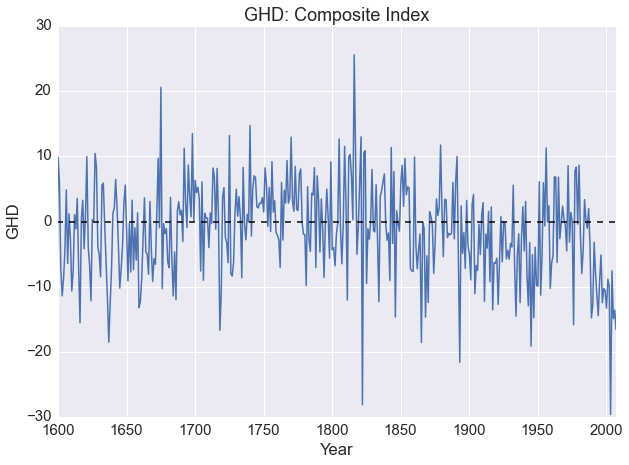

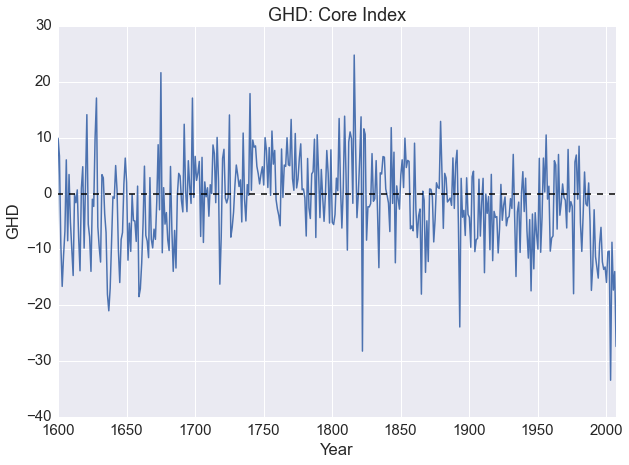

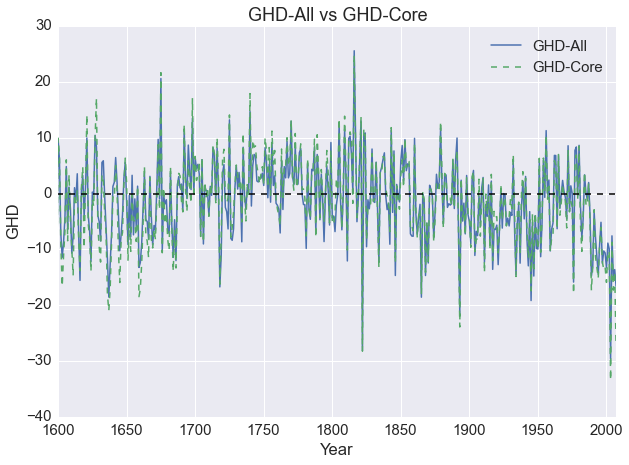

In [172]:
# Create and plot Average Index   
ghd_mean_all  = np.nanmean(ghd_doy_anom,axis=1) 
ghd_mean_core = np.nanmean(ghd_doy_anom[:,core_locs],axis=1) 
     
# Line of Zeros
line_zero = np.zeros(np.size(yr))   
     
# Figure for Composite Index
sns.set(style="darkgrid")
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 1.5})
sns.plt.figure(figsize=[10,7])
sns.plt.plot(yr,ghd_mean_all)
sns.plt.plot(yr,line_zero,'--', color='k')
sns.plt.xlabel('Year')
sns.plt.ylabel('GHD')
sns.plt.title('GHD: Composite Index')
sns.plt.tight_layout
sns.plt.xlim(1600,2007)
#sns.plt.savefig('./figures/step01/ghd_composite_time.svg', format='svg', dpi=1200) # vector graphics for adobe illustrator 
sns.plt.savefig('../figures/step01/ghd_composite_time.eps', format='eps', dpi=1200) # vector graphics for adobe illustrator 
   
# Figure for Core Index
sns.set(style="darkgrid")
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 1.5})
sns.plt.figure(figsize=[10,7])
sns.plt.plot(yr,ghd_mean_core)
sns.plt.plot(yr,line_zero,'--', color='k')
sns.plt.xlabel('Year')
sns.plt.ylabel('GHD')
sns.plt.title('GHD: Core Index')
sns.plt.tight_layout
sns.plt.xlim(1600,2007)
#sns.plt.savefig('./figures/step01/ghd_core_time.svg', format='svg', dpi=1200) # vector graphics for adobe illustrator     
sns.plt.savefig('../figures/step01/ghd_core_time.eps', format='eps', dpi=1200) # vector graphics for adobe illustrator     
       
# Figure for Composite AND Core Index
sns.set(style="darkgrid")
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 1.5})
sns.plt.figure(figsize=[10,7])
sns.plt.plot(yr,ghd_mean_all)
sns.plt.plot(yr,ghd_mean_core,'--')
sns.plt.plot(yr,line_zero,'--', color='k')
sns.plt.xlabel('Year')
sns.plt.ylabel('GHD')
sns.plt.title('GHD-All vs GHD-Core')
sns.plt.legend(['GHD-All','GHD-Core'])
sns.plt.tight_layout
sns.plt.xlim(1600,2007)
#sns.plt.savefig('./figures/step01/ghd_core_and_comp_time.svg', format='svg', dpi=1200) # vector graphics for adobe illustrator 
sns.plt.savefig('../figures/step01/ghd_core_and_ghd_all_time.eps', format='eps', dpi=1200) # vector graphics for adobe illustrator 




In [173]:
# Just Some Debugging

# So I can see years associated with core index anomalies
df_new= pd.DataFrame(ghd_mean_core, index=yr, columns={'GHDcore'})

# Print GHD Anomalies for 2003 and 2007 (earliest from most recent period)
print('GHD, 2003: '+np.str(df_new.GHDcore[2003]))
print('GHD, 2007: '+np.str(df_new.GHDcore[2007]))

print('')

# T-test results (most recent period vs previous)
tt_ghd = stats.ttest_ind(ghd_mean_core[yr_loc_1600_1980], ghd_mean_core[yr_loc_1981_2007])
print('Students t-test, 2-sided: 1600-1980 vs 1981-2007')
print('t-stat: ',tt_ghd[0])
print('pval: ',tt_ghd[1])


GHD, 2003: -33.4457101184
GHD, 2007: -27.3903654485

Students t-test, 2-sided: 1600-1980 vs 1981-2007
t-stat:  6.40308904617
pval:  4.21357315649e-10


In [174]:
# Calculate Stats (Mean, St Dev) for Core and Composite Time Series over various intervals

# Initialize Array to Store All Standard Deviations/Mean Values
mean_core_comp = np.float64(np.zeros((5,2)))
std_core_comp  = np.float64(np.zeros((5,2)))
       
# MEAN, Core/Comp Index
mean_core_comp[0,0] = np.nanmean(ghd_mean_core[yr_loc_base]); mean_core_comp[0,1] = np.nanmean(ghd_mean_all[yr_loc_base]);      
mean_core_comp[1,0] = np.nanmean(ghd_mean_core[yr_loc_1600_1980]); mean_core_comp[1,1] = np.nanmean(ghd_mean_all[yr_loc_1600_1980]);      
mean_core_comp[2,0] = np.nanmean(ghd_mean_core[yr_loc_1901_1950]); mean_core_comp[2,1] = np.nanmean(ghd_mean_all[yr_loc_1901_1950]);      
mean_core_comp[3,0] = np.nanmean(ghd_mean_core[yr_loc_1951_1980]); mean_core_comp[3,1] = np.nanmean(ghd_mean_all[yr_loc_1951_1980]);      
mean_core_comp[4,0] = np.nanmean(ghd_mean_core[yr_loc_1981_2007]); mean_core_comp[4,1] = np.nanmean(ghd_mean_all[yr_loc_1981_2007]);      

# St. Deviation, Core/Comp Index
std_core_comp[0,0] = np.nanstd(ghd_mean_core[yr_loc_base]); std_core_comp[0,1] = np.nanstd(ghd_mean_all[yr_loc_base]);      
std_core_comp[1,0] = np.nanstd(ghd_mean_core[yr_loc_1600_1980]); std_core_comp[1,1] = np.nanstd(ghd_mean_all[yr_loc_1600_1980]);      
std_core_comp[2,0] = np.nanstd(ghd_mean_core[yr_loc_1901_1950]); std_core_comp[2,1] = np.nanstd(ghd_mean_all[yr_loc_1901_1950]);      
std_core_comp[3,0] = np.nanstd(ghd_mean_core[yr_loc_1951_1980]); std_core_comp[3,1] = np.nanstd(ghd_mean_all[yr_loc_1951_1980]);      
std_core_comp[4,0] = np.nanstd(ghd_mean_core[yr_loc_1981_2007]); std_core_comp[4,1] = np.nanstd(ghd_mean_all[yr_loc_1981_2007]);      

# Put this info into Dataframes
# Indices/Label
col_core_comp_txt=["GHD-Core","GHD-Comp"]
row_core_comp_txt=["1600-1900","1600-1980","1901-1950","1951-1980","1981-2007"]

# Create Data Frames
df_mean_core_comp = pd.DataFrame(mean_core_comp, index=row_core_comp_txt, columns=col_core_comp_txt)
df_std_core_comp  = pd.DataFrame(std_core_comp, index=row_core_comp_txt, columns=col_core_comp_txt)

print("Mean GHD Anomalies")
df_mean_core_comp


Mean GHD Anomalies


,GHD-Core,GHD-Comp
1600-1900,-0.353676,-0.253742
1600-1980,-0.905132,-0.845885
1901-1950,-4.488009,-5.132239
1951-1980,-0.466607,0.356875
1981-2007,-10.616986,-8.905504


In [175]:
print("St. Dev. GHD Anomalies")
df_std_core_comp


St. Dev. GHD Anomalies


,GHD-Core,GHD-Comp
1600-1900,7.795869,7.025305
1600-1980,7.573852,7.015729
1901-1950,5.498504,5.552474
1951-1980,6.610891,6.552565
1981-2007,7.920924,6.753326


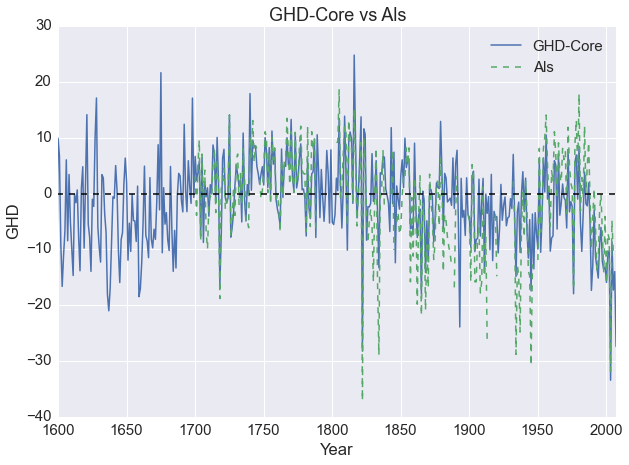

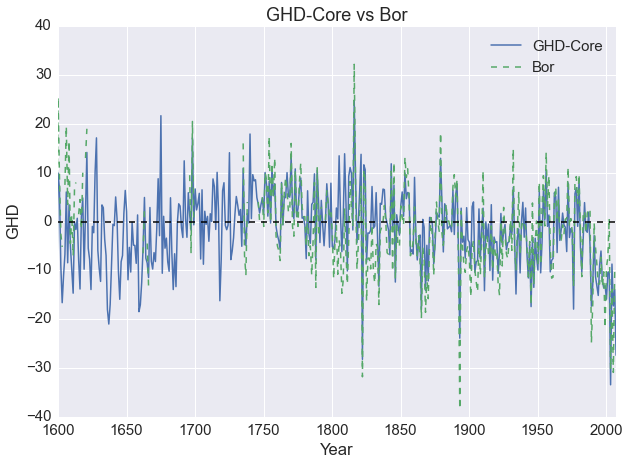

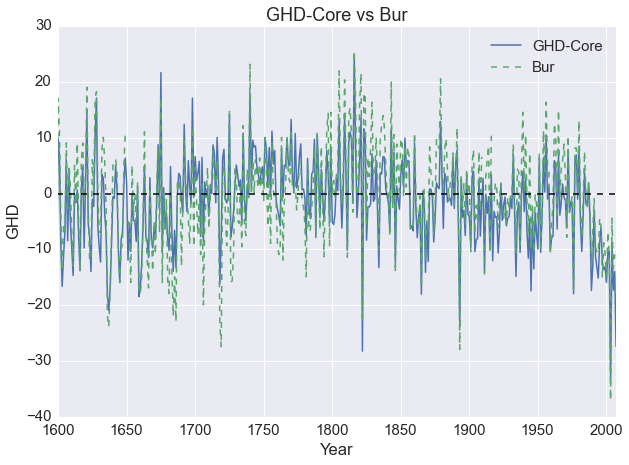

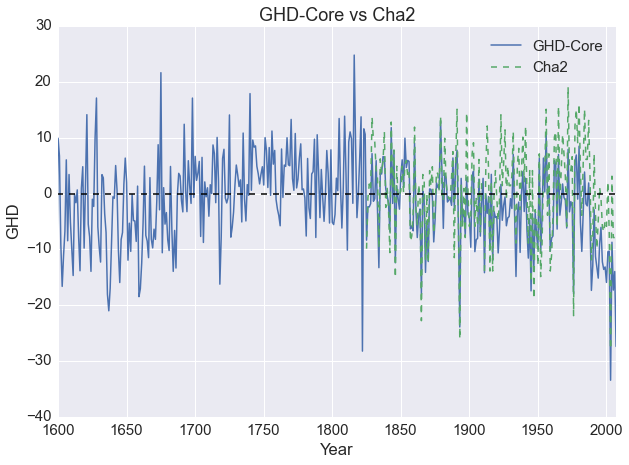

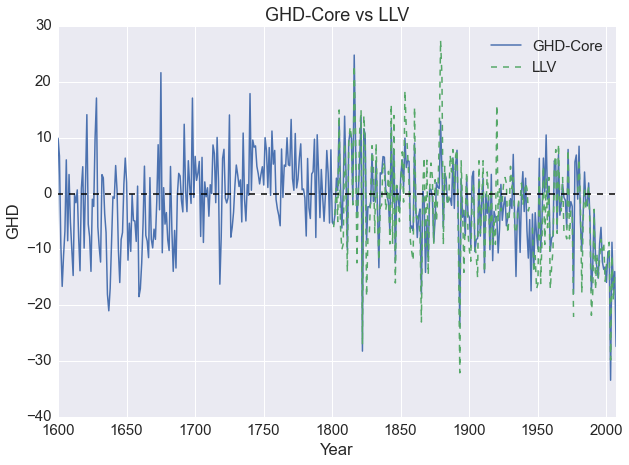

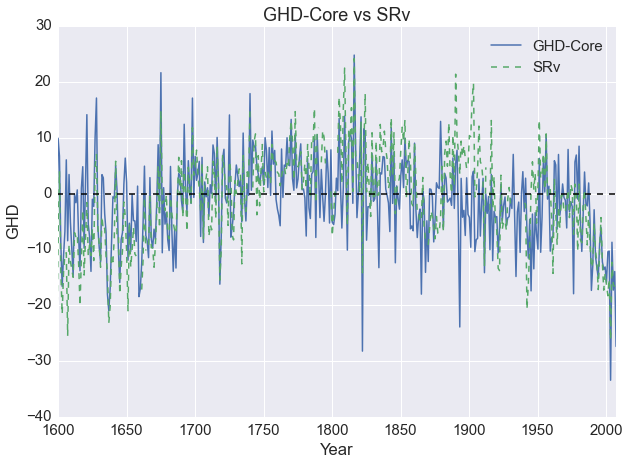

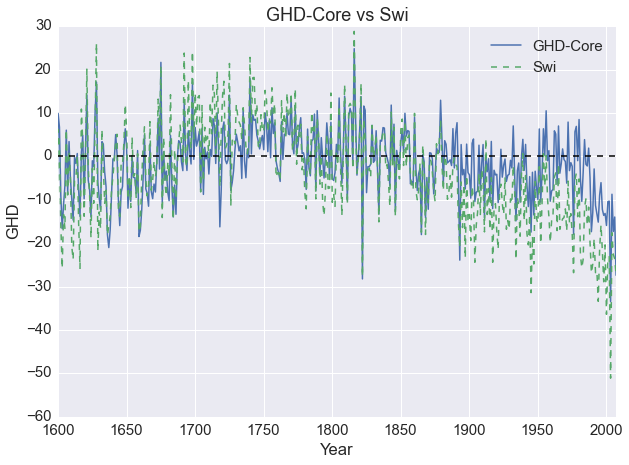

In [176]:
# Figures Comparing Each Individual Series against the Core Series

for num_series in enumerate(core_names):
    #print(num_series[0])

    # Series Name and Series Index
    series_name = core_names[num_series[0]]
    ghd_series  = ghd_doy_anom[:,core_locs[num_series[0]]]

    sns.set(style="darkgrid")
    sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 1.5})
    sns.plt.figure(figsize=[10,7])
    sns.plt.plot(yr,ghd_mean_core)
    sns.plt.plot(yr,ghd_series,'--')
    sns.plt.plot(yr,line_zero,'--', color='k')
    sns.plt.xlabel('Year')
    sns.plt.ylabel('GHD')
    sns.plt.title('GHD-Core vs '+series_name)
    sns.plt.legend(['GHD-Core',series_name])
    sns.plt.tight_layout
    sns.plt.xlim(1600,2007)
    #sns.plt.savefig('./figures/step01/ghd_core_and_comp_time.svg', format='svg', dpi=1200) # vector graphics for adobe illustrator 
    sns.plt.savefig('../figures/step01/ghd_core_and_'+series_name+'_time.eps', format='eps', dpi=1200) # vector graphics for adobe illustrator 


In [177]:
# Conduct correlations between different individual regional indices in the Core index

# Years to correlate
i_corr = np.where(yr>=1300)[0]; time_corr = 'All Years';   

# Storage for all correlations (Spearman and Pearson)
rho_all_spear    = np.zeros((np.size(core_locs),np.size(core_locs))); rho_all_pears  = copy.deepcopy(rho_all_spear);
pval_all_spear   = np.zeros((np.size(core_locs),np.size(core_locs))); pval_all_pears = copy.deepcopy(pval_all_spear);

# Loop through Each Series and Compare Against Every Other One via a nested loop

# Series (1)
for num_series_1 in enumerate(core_names):
    #print(num_series[0])

    # Series (1) Name and Series Index
    series_name_1 = core_names[num_series_1[0]]
    ghd_series_1  = ghd_doy_anom[i_corr,core_locs[num_series_1[0]]]

# Series (2)
    for num_series_2 in enumerate(core_names):

        # Series (1) Name and Series Index
        series_name_2 = core_names[num_series_2[0]]
        ghd_series_2  = ghd_doy_anom[i_corr,core_locs[num_series_2[0]]]

        #print([num_series_1[0],num_series_2[0]])

        # Find Locations of Real Values in Each (not NAN, not missing)
        realvals = np.where( (~np.isnan(ghd_series_1)) & (~np.isnan(ghd_series_2)) )[0]  
        
        # Calculate Correlations (Spearman and Pearson)
        rho_all_spear[num_series_1[0],num_series_2[0]],pval_all_spear[num_series_1[0],num_series_2[0]] = \
            stats.spearmanr(ghd_series_1[realvals], ghd_series_2[realvals])

        rho_all_pears[num_series_1[0],num_series_2[0]],pval_all_pears[num_series_1[0],num_series_2[0]] = \
            stats.pearsonr(ghd_series_1[realvals], ghd_series_2[realvals])
            
            
# Now, correlate core index and composite index
rho_coreVcomp,pval_coreVcomp = stats.spearmanr(ghd_mean_all[i_corr],ghd_mean_core[i_corr]) 

# Put Correlations in a Dataframe
df_rho_core_spear = pd.DataFrame(rho_all_spear, index=core_names, columns=core_names)
df_rho_core_pears = pd.DataFrame(rho_all_pears, index=core_names, columns=core_names)

print('Spearmans Rank Correlations: '+time_corr)
df_rho_core_spear


Spearmans Rank Correlations: All Years


,Als,Bor,Bur,Cha2,LLV,SRv,Swi
Als,1.000000,0.601045,0.573844,0.632206,0.502502,0.413751,0.604378
Bor,0.601045,1.000000,0.615465,0.675208,0.712442,0.248981,0.553595
Bur,0.573844,0.615465,1.000000,0.798581,0.775801,0.456186,0.562137
Cha2,0.632206,0.675208,0.798581,1.000000,0.709044,0.346222,0.569444
LLV,0.502502,0.712442,0.775801,0.709044,1.000000,0.456008,0.696642
SRv,0.413751,0.248981,0.456186,0.346222,0.456008,1.000000,0.500804
Swi,0.604378,0.553595,0.562137,0.569444,0.696642,0.500804,1.000000


In [178]:
print('Pearsons r Correlations: '+time_corr)
df_rho_core_pears


Pearsons r Correlations: All Years


,Als,Bor,Bur,Cha2,LLV,SRv,Swi
Als,1.000000,0.624877,0.599068,0.680461,0.525393,0.445166,0.630186
Bor,0.624877,1.000000,0.660126,0.716800,0.761878,0.268540,0.611979
Bur,0.599068,0.660126,1.000000,0.831738,0.810783,0.497955,0.584311
Cha2,0.680461,0.716800,0.831738,1.000000,0.735722,0.376924,0.599031
LLV,0.525393,0.761878,0.810783,0.735722,1.000000,0.489171,0.725922
SRv,0.445166,0.268540,0.497955,0.376924,0.489171,1.000000,0.522562
Swi,0.630186,0.611979,0.584311,0.599031,0.725922,0.522562,1.000000


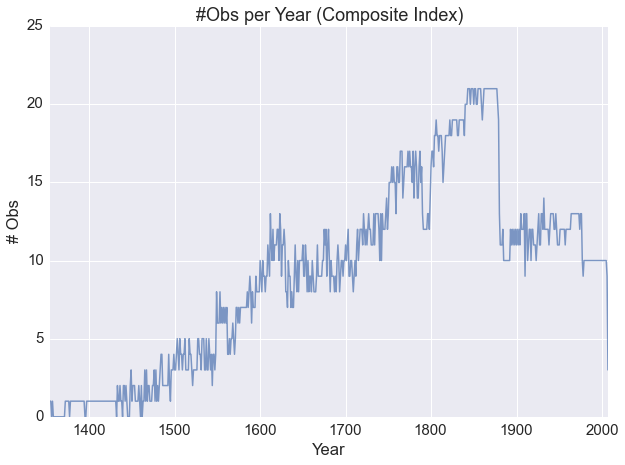

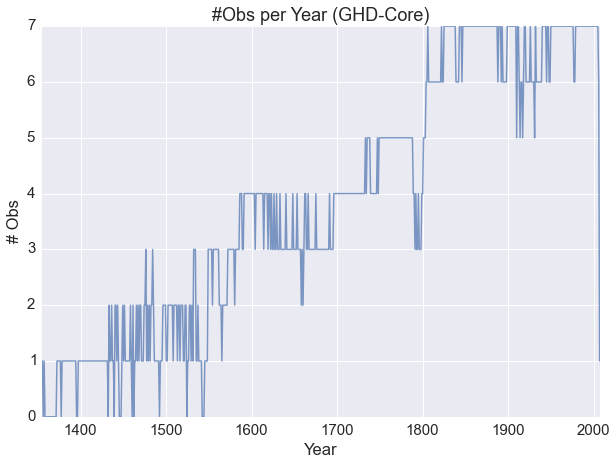

In [179]:
# Bar plot of sample depth
# Find valid (NOT NAN) Observations: Composite Index
valid_obs = ~np.isnan(ghd_doy_anom)   # Boolean indicating missing values or not
valid_obs = np.float64(valid_obs)     # Convert Boolean array to 1s and 0s

# Sum them up
num_obs = np.sum(valid_obs,axis=1)

# COMPOSITE INDEX
# Bar Plot Figure
sns.plt.figure(figsize=[10,7]) 
sns.plt.plot(yr,num_obs,'-',alpha=0.7);
sns.plt.xlabel('Year')
sns.plt.ylabel('# Obs')
sns.plt.title('#Obs per Year (Composite Index)')  
sns.plt.tight_layout
sns.plt.xlim(np.min(yr),np.max(yr))
#sns.plt.savefig('./figures/step01/num_obs_comp_index_bar.svg', format='svg', dpi=1200) # vector graphics for adobe illustrator        
sns.plt.savefig('../figures/step01/num_obs_comp_index_bar.eps', format='eps', dpi=1200) # vector graphics for adobe illustrator        

# Bar plot of sample depth
# Find valid (NOT NAN) Observations: Core Index
core_all=ghd_doy_anom[:,core_locs];
valid_obs = ~np.isnan(core_all)
valid_obs = np.float64(valid_obs)

# Sum them up
num_obs = np.sum(valid_obs,axis=1)

# Sample Depth Figure
sns.set(style="darkgrid")
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 1.5})
sns.plt.figure(figsize=[10,7]) 
sns.plt.plot(yr,num_obs,'-',alpha=0.7);
sns.plt.xlabel('Year')
sns.plt.ylabel('# Obs')
sns.plt.title('#Obs per Year (GHD-Core)')  
sns.plt.tight_layout
sns.plt.xlim(np.min(yr),np.max(yr))
#sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 1.5})
#sns.plt.savefig('./figures/step01/num_obs_core_index_bar.svg', format='svg', dpi=1200) # vector graphics for adobe illustrator   
sns.plt.savefig('../figures/step01/num_obs_core_index_bar.eps', format='eps', dpi=1200) # vector graphics for adobe illustrator   


Mean GHD (modern) = -10.6169862241
Median GHD (modern) = -10.4314244041


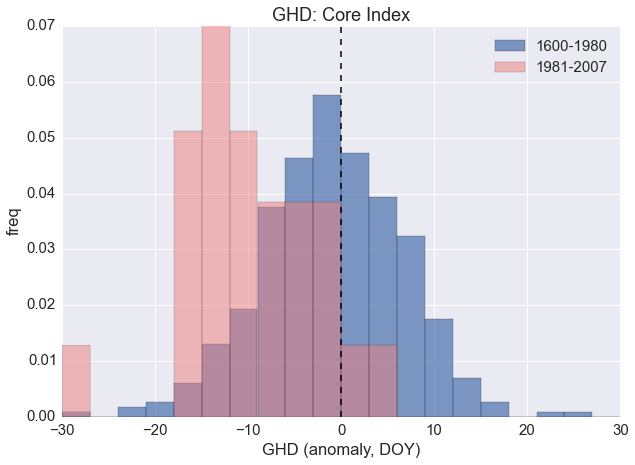

In [180]:
# Plot up historgrams for the CORE Index comparing different periods

# Set Bin Edges   
bins=np.arange(-30,33,3)

# Always use the same base period, 1600-1900
ghd_before    = ghd_mean_core[yr_loc_1600_1980]; yrs_before=copy.deepcopy(period_1600_1980)

# Vary the modern interval to compare against
#ghd_modern    = ghd_mean_core[yr_loc_1901_1950]; yrs_modern = copy.deepcopy(period_1901_1950) 
#ghd_modern    = ghd_mean_core[yr_loc_1951_1980]; yrs_modern = copy.deepcopy(period_1951_1980)  
ghd_modern    = ghd_mean_core[yr_loc_1981_2007]; yrs_modern = copy.deepcopy(period_1981_2007)  
       
# Text for legend
legtxt_before    = np.str(np.min(yrs_before)) + '-' + np.str(np.max(yrs_before));
legtxt_modern    = np.str(np.min(yrs_modern)) + '-' + np.str(np.max(yrs_modern));

# HISTOGRAM
sns.plt.figure(figsize=[10,7])     
sns.plt.hist(ghd_before, bins, normed=True, alpha=0.7);
sns.plt.hist(ghd_modern, bins, normed=True, color="#F08080", alpha=.5);
#sns.plt.hist(ghd_1980_2007, bins, normed=True, color="#57AFC8", alpha=.5);
sns.plt.legend([legtxt_before,legtxt_modern])
sns.plt.plot([0,0],[0,0.09],'--', color='k')
sns.plt.xlabel('GHD (anomaly, DOY)')
sns.plt.ylabel('freq')
sns.plt.title('GHD: Core Index')  
sns.plt.tight_layout
sns.plt.ylim(0,0.07)
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 1.5}) 
sns.plt.savefig('../figures/step01/ghd_core_hist.'+legtxt_modern+'.svg', format='svg', dpi=1200) # vector graphics for adobe illustrator 
#sns.plt.savefig('./figures/step01/ghd_comp_hist.'+legtxt_modern+'.eps', format='eps', dpi=1200) # vector graphics for adobe illustrator 

# Calculate mean and median
mean_modern   = np.nanmean(ghd_modern)
median_modern = np.nanmedian(ghd_modern)

print('Mean GHD (modern) = '+np.str(mean_modern))
print('Median GHD (modern) = '+np.str(median_modern))

In [181]:
# Output Anomalized Data as New Dataframe
df_ghd_anom = pd.DataFrame(data=ghd_doy_anom, index=yr, columns=df.columns)

# Add new dummy columns for core and composite index
df_ghd_anom["GHDmean"] = np.nan
df_ghd_anom["GHDcore"] = np.nan

# Fill this duymmy column with the mean values
df_ghd_anom.GHDmean = ghd_mean_all
df_ghd_anom.GHDcore = ghd_mean_core

# Name the Index
df_ghd_anom.index.name='Year'

# Save GHD for all sites (and composite and core), converted to GHD anomalies
outfile = '../data/ghd_anom_doy_v02.csv'    # name of output file
if os.path.exists(outfile):
    os.remove(outfile); 
df_ghd_anom.to_csv(outfile,sep=',')    # save to file
